<a href="https://colab.research.google.com/github/romybompart/SelfDrivingCar_Learning/blob/master/roadTrafficSignalsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs.git

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [3]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import cv2

Using TensorFlow backend.


In [0]:
np.random.seed(0)


In [6]:
#with automatically close the file for us
# as works to down casting the information as f
with open('german-traffic-signs/train.p', 'rb') as f: 
  train_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f: 
  test_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f: 
  valid_data = pickle.load(f)

print ( type(train_data))
xtrain, ytrain = train_data['features'], train_data['labels']
xtest, ytest = test_data['features'], test_data['labels']
xval, yval = valid_data['features'], valid_data['labels']

<class 'dict'>


In [7]:
print(xtrain.shape)
print(xtest.shape)
print(xval.shape)
print(ytest.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)
(12630,)


In [0]:
#make sure the information that importing is consistent
assert(xtrain.shape[0]==ytrain.shape[0]), "number of data and labels are not equals"
assert(xtest.shape[0]==ytest.shape[0]), "number of data and labels are not equals"
assert(xval.shape[0]==yval.shape[0]), "number of data and labels are not equals"
assert(xtrain.shape[1:]==(32,32,3)), "the dimesion of the images are not 32x32,3"
assert(xtest.shape[1:]==(32,32,3)), "the dimesion of the images are not 32x32,3"
assert(xval.shape[1:]==(32,32,3)), "the dimesion of the images are not 32x32,3"


In [9]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print (data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

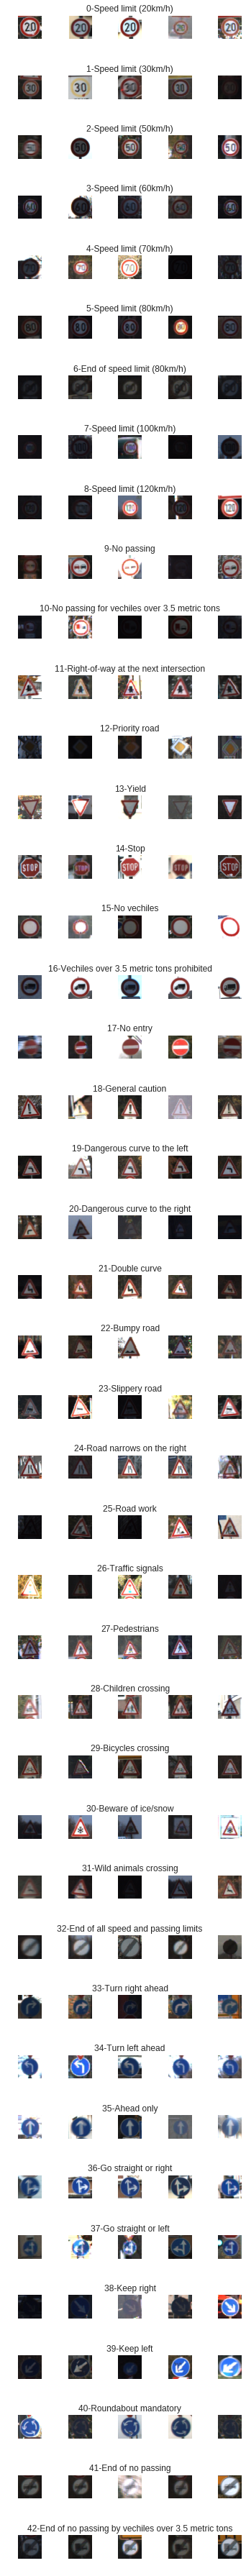

In [10]:
num_of_samples = [] 
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows(): 
        x_selected = xtrain[ytrain == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))


Text(0, 0.5, 'Number of images')

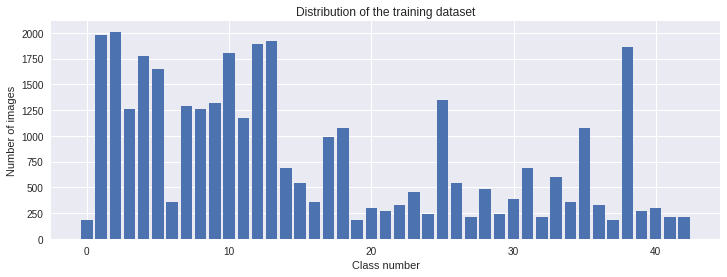

In [11]:
#print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
13


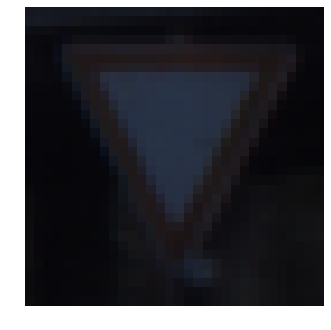

In [12]:
imageIndex= random.randint(0, len(xtrain - 1))
plt.imshow(xtrain[imageIndex])
plt.axis("off")
print(xtrain[imageIndex].shape)
print(ytrain[imageIndex])

(32, 32)


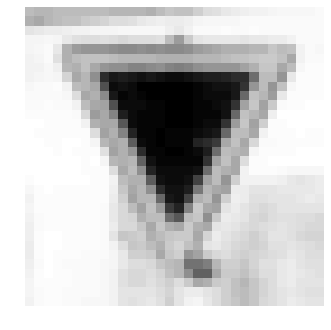

In [13]:
#converting in gray scale
def grayscale(img):
  IMG = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return IMG

img = grayscale(xtrain[imageIndex])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


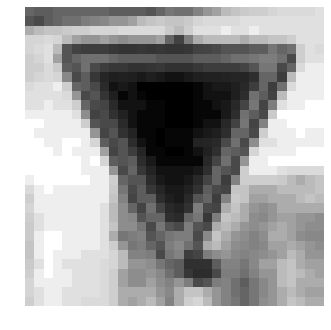

In [14]:
#similar brightness using histogramic equalization
#histogram equalize only accepts gray scale images
def equalize(img):
  IMG = cv2.equalizeHist(img)
  return IMG

img = equalize(img)

plt.imshow(img)
plt.axis("off")
print(img.shape)

In [0]:
def preprocessing(img):
  IMG = grayscale(img)
  IMG = equalize(IMG)
  IMG = IMG/255
  return IMG

#iterate through the entire dataset
xtrain = np.array(list(map(preprocessing, xtrain)))
xtest = np.array(list(map(preprocessing, xtest)))
xval = np.array(list(map(preprocessing, xval)))

(34799, 32, 32)


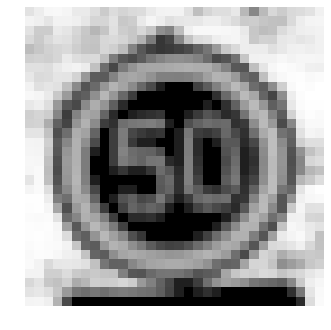

In [16]:
plt.imshow(xtrain[random.randint(0, len(xtrain - 1))])
plt.axis("off")
print(xtrain.shape)

In [17]:
xtrain = xtrain.reshape(xtrain.shape[0], xtrain.shape[1], xtrain.shape[2], 1)
xtest = xtest.reshape(xtest.shape[0], xtest.shape[1], xtest.shape[2], 1)
xval = xval.reshape(xval.shape[0], xval.shape[1], xval.shape[2], 1)

print ( xtrain.shape)
print ( xtest.shape)
print ( xval.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [0]:
ytrain = to_categorical(ytrain, num_classes)
ytest = to_categorical(ytest, num_classes)
yval = to_categorical(yval, num_classes)

In [0]:
def leNet_modified_model():
  model = Sequential()
  #input 32x32x1
  #fine tunning increase the number of filters will allow the model to capture more data
  model.add(Conv2D(filters=60,kernel_size = (5,5), input_shape=(xtrain.shape[1],xtrain.shape[2], xtrain.shape[3]), activation='relu'))
  #fine tunning increasing the number of convolution layers can gather more specific data
  model.add(Conv2D(filters=60,kernel_size = (5,5), activation='relu'))
  
  #reduced to 32-(5-1) = 28. to 28x28x30
  model.add(MaxPooling2D(pool_size= (2,2), padding = 'valid'))
  #reduced to be 28/2, because the pool size is taking only the max value each operation
  #dimension will be then 14x14x30
  model.add(Conv2D(filters=30,kernel_size = (3,3), activation = 'relu'))
  model.add(Conv2D(filters=30,kernel_size = (3,3), activation = 'relu'))
  #dimesion will be then 14 - (3-1) = 12. 12x12x15
  model.add(MaxPooling2D(pool_size= (2,2), padding = 'valid'))
  model.add(Dropout(rate = 0.5))
  
  #flattern the layer
  model.add(Flatten())
  #fully connected layer
  model.add(Dense(units=500, activation='relu'))
  model.add(Dropout(rate = 0.5))
  model.add(Dense(units=num_classes, activation='softmax'))
  #fine tunning change lr to be smaller from 0.01 to 0.001
  model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [51]:
model = leNet_modified_model()
print ( model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 30)          0         
__________

In [52]:
h = model.fit(xtrain, ytrain, epochs = 10, validation_data = (xval, yval), batch_size = 400, verbose = 1, shuffle = 1)

Train on 34799 samples, validate on 4410 samples
Epoch 1/10
34799/34799 [==============================] - 6s 167us/step - loss: 2.2319 - acc: 0.3944 - val_loss: 0.6873 - val_acc: 0.8102
Epoch 2/10
34799/34799 [==============================] - 5s 144us/step - loss: 0.6796 - acc: 0.7920 - val_loss: 0.2861 - val_acc: 0.9118
Epoch 3/10
34799/34799 [==============================] - 5s 145us/step - loss: 0.3937 - acc: 0.8775 - val_loss: 0.1830 - val_acc: 0.9449
Epoch 4/10
34799/34799 [==============================] - 5s 144us/step - loss: 0.2877 - acc: 0.9101 - val_loss: 0.1469 - val_acc: 0.9551
Epoch 5/10
34799/34799 [==============================] - 5s 145us/step - loss: 0.2261 - acc: 0.9290 - val_loss: 0.1144 - val_acc: 0.9658
Epoch 6/10
34799/34799 [==============================] - 5s 145us/step - loss: 0.1868 - acc: 0.9421 - val_loss: 0.0975 - val_acc: 0.9726
Epoch 7/10
34799/34799 [==============================] - 5s 146us/step - loss: 0.1655 - acc: 0.9477 - val_loss: 0.0858 - v

Text(0.5, 0, 'epoch')

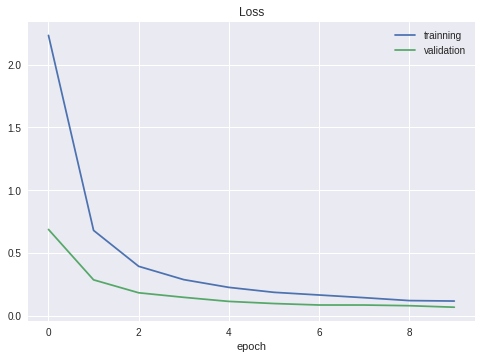

In [53]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['trainning', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

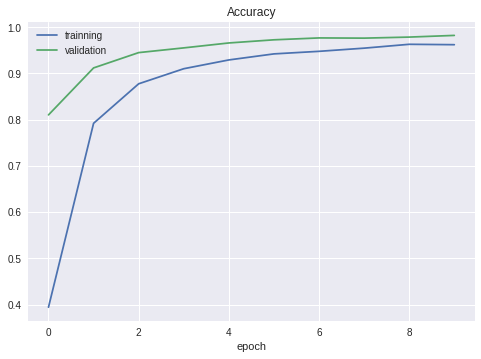

In [54]:
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['trainning', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [55]:
score = model.evaluate(xtest,ytest,verbose = 0)
print ( 'Test Score: ', score[0])
print ( 'Test Acc:', score[1])

Test Score:  0.14187539591854373
Test Acc: 0.9604908946857317


In [0]:
#Network overfitting is when the validation acc is behind/bellow the trainning data.


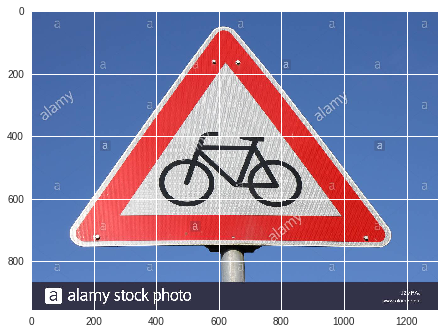

In [56]:
#fetch image
 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 

(32, 32)


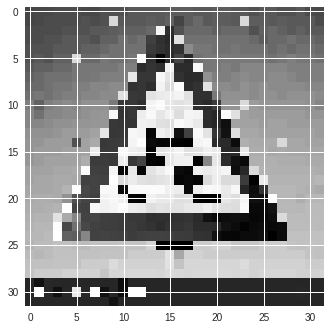

In [57]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 

In [0]:
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 

In [61]:
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [5]
